In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as time
from torchinfo import summary
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [2]:
train_rice = "ext/RiceLeafsDisease/train"
test_rice = "ext/RiceLeafsDisease/validation"

In [4]:
# Define the transforms
train_transforms = .transformsCompose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(train_rice, transform=train_transforms)
val_dataset = datasets.ImageFolder(test_rice, transform=val_transforms)


In [9]:
"""The torch.utils.data.DataLoader in PyTorch provides an efficient way to load and iterate over batches of data
during the training or evaluation of machine learning models.
"""
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print some statistics

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 2100
Validation set size: 528


In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_idx = self.data[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, class_idx





In [12]:
# Create dataset
# Define the model
from timeit import default_timer as timer
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the custom model
class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB3, self).__init__()
        self.efficientnet = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.efficientnet.classifier = nn.Sequential(
            nn.BatchNorm1d(self.efficientnet.classifier[1].in_features),
            nn.Dropout(p=0.5),
            nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

num_classes = 6  # Update this to match your number of classes
model = CustomEfficientNetB3(num_classes=num_classes)



In [13]:
# Model summary
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomEfficientNetB3 (CustomEfficientNetB3)                       [32, 3, 224, 224]    [32, 6]              --                   True
├─EfficientNet (efficientnet)                                     [32, 3, 224, 224]    [32, 6]              --                   True
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   True
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   1,160                True
│    │    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 24, 112, 112]   3,504                True
│    │    └─Sequential (2)                                        [32, 24, 112, 112]   [32, 32, 56, 56]     48,118               True
│    │    └─Sequential (3)                               

In [14]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               epoch: int):
  # put model to train mode
  model.train()

  # set train loss
  train_loss = 0
  train_acc = 0

  #loop through dataloader batches

  for X,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
    # forward passs
    X,y = X.to(device),y.to(device)
    y_logit = model(X)

    # calculate the loss

    loss=loss_fn(y_logit,y)
    train_loss += loss.item()


    #optimizer zero grad

    optimizer.zero_grad()

    #loss backward

    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric across all batches
    y_pred_label = torch.argmax(torch.softmax(y_logit,dim=1),dim=1)
    train_acc +=(y_pred_label == y).sum().item()/len(y_logit)

  # return train loss and train accuracy
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss,train_acc

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              epoch: int):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing"):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [19]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: optim.Optimizer,
          # scheduler: optim.lr_scheduler._LRScheduler,
          epochs: int = 5,
          device: torch.device = 'cuda'):
    # Empty list for training and test loss
    result = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           epoch=epoch)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        epoch=epoch)

        # Printing what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update result
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        # scheduler.step()

    return result


In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the number of epochs
num_epochs = 5 # Increase this if necessary

# Define loss function, optimizer, and scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
start_time = time()
# Train the model
model_result=train(model=model,
      train_dataloader=train_loader,
      test_dataloader=val_loader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      # scheduler=scheduler,
      epochs=num_epochs,
      device=device)
end_time = time()
print(f"Total training time : {end_time - start_time:.3f}  seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1/5 - Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0649 | train_acc: 0.6212 | test_loss: 0.4884 | test_acc: 0.8585


Epoch 2/5 - Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2/5 - Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6320 | train_acc: 0.7687 | test_loss: 0.2449 | test_acc: 0.9246


Epoch 3/5 - Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3/5 - Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5333 | train_acc: 0.8115 | test_loss: 0.3063 | test_acc: 0.9173


Epoch 4/5 - Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4/5 - Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4607 | train_acc: 0.8302 | test_loss: 0.2075 | test_acc: 0.9357


Epoch 5/5 - Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 5/5 - Testing:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.4574 | train_acc: 0.8334 | test_loss: 0.2366 | test_acc: 0.9026
Total training time : 3295.303  seconds


In [21]:
from typing import Dict, List
def plot_loss_curves(results: Dict [str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
   
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

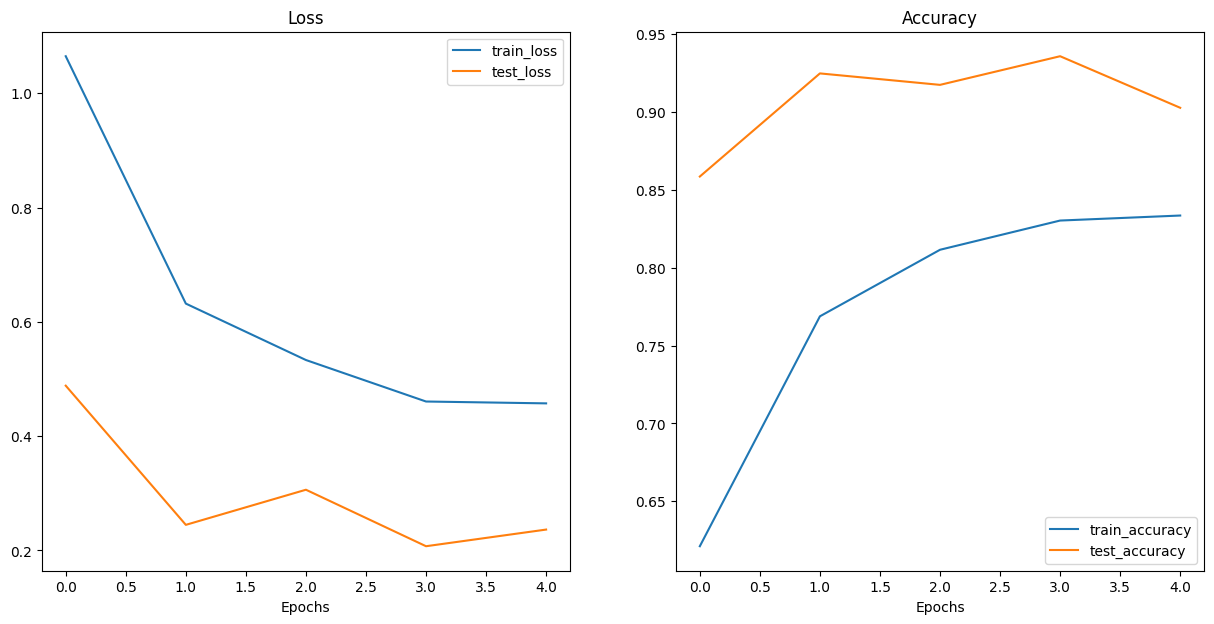

In [22]:
import matplotlib.pyplot as plt
plot_loss_curves(model_result)

In [23]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("model2")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "newped.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: model2\newped.pth
